# Interpolant function ofr the starting time in the progenitor parameter space for non-precessing ringdown models

This notebook visualizes the interpolated function of the starting time $t_{\rm start}$ in the progenitor parameter space $(\eta,\chi_+,\chi_-)$, for a given ringdown model.

**Imports & Settings**

In [1]:
# Scientific / numeric
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Animation / display
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Plot configuration
rcParams['text.usetex'] = False
rcParams['font.size']   = 22

**Ask user the model and the $(\ell,|m|)$ mode to analyze**

As default, will choose the $\texttt{London}$ model with $(\ell,m)=(2,2)$.

In [ ]:
# =======================================
# Select waveform model and spherical-harmonic mode
# =======================================

available_models = ["KerrBinary_London", "KerrBinary_Cheung", "TEOBPM"]
available_modes  = ["22", "21", "33", "32", "44"]

default_model = "KerrBinary_London"
default_mode  = "22"

def prompt_choice(prompt, options, default):
    """
    Utility: prompt user for option, with fallback default.
    Re-prompts until valid choice is given.
    """
    print(prompt)
    for opt in options:
        print(f"  - {opt}")

    choice = input(f"Enter choice [{default}]: ").strip() or default

    while choice not in options:
        print(f"❌ Invalid choice. Please select from the list above.")
        choice = input(f"Enter choice [{default}]: ").strip() or default

    return choice

# Ask user
model = prompt_choice("\nSelect a ringdown model:", available_models, default_model)
mode  = prompt_choice("\nSelect an angular mode:",  available_modes,  default_mode)

# Confirm selection
print(f"\n✅ Selected model: {model}")
print(f"✅ Selected mode:  {mode}")


Select a ringdown model:
  - KerrBinary_London
  - KerrBinary_Cheung
  - TEOBPM

Select an angular mode:
  - 22
  - 21
  - 33
  - 32
  - 44

✅ Selected model: KerrBinary_London
✅ Selected mode:  22


**Load mismatch results and NR simulations information**

Data are loaded directly from the GitHub repository.

* `avg_mismatches_all_times.npz`: contains, for the London, Cheung and TEOBPM models, the $(\ell,m)$ mismatch values for different starting times, where $(\ell,m)=\{(2,2),(2,1),(3,3),(3,2),(4,4)\}$.

* `SXS_BBH_nonprec_nonecc_all.txt`: to each simulation, we associate the triplet $(\eta,\chi_{+},\chi_{-})$.

In [ ]:
# =======================================
# Load mismatch data and NR catalog
# =======================================

# Download data (only needed once, safe if already exists)
!wget -q -P files/ https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz
!wget -q -P files/ https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/SXS_BBH_nonprec_nonecc_all.txt

# ---------------------------------------
# File paths
# ---------------------------------------
npz_file     = "files/avg_mismatches_all_times.npz"
catalog_file = "files/SXS_BBH_nonprec_nonecc_all.txt"

# ---------------------------------------
# Load mismatch dictionary (NR grid data)
# ---------------------------------------
data           = np.load(npz_file, allow_pickle=True)
avg_mismatches = data["avg_mismatches"].item()

# ---------------------------------------
# Parse SXS catalog: extract (η, χ+, χ−)
# ---------------------------------------
id_info = {}

with open(catalog_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue

        fields = line.split()
        if len(fields) < 7:
            continue

        try:
            sim_id = fields[0]
            id_info[sim_id] = {
                "eta" : float(fields[2]),
                "chip": float(fields[5]),
                "chim": float(fields[6]),
            }
        except Exception:
            pass  # skip malformed entries

print(f"✅ Loaded {len(id_info)} simulations from catalog")


--2025-11-03 12:25:27--  https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz
Resolving github.com (github.com)... 20.26.156.215
Connecting to github.com (github.com)|20.26.156.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz [following]
--2025-11-03 12:25:27--  https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 583752 (570K) [application/octet-stream]
Saving to: ‘files/avg_mismatc

**Ask user the input values $(\eta_i,\chi_{+,i},\chi_{-,i})$ values and mismatch threshold $\mathcal{M}_{\rm th}$**

These values will be needed to compute the output starting time $t^{(i)}_{\rm start}=t_{\rm start}(\eta_i,\chi_{+,i},\chi_{-,i}|\mathcal{M}_{\rm th})$.

**For a given $\mathcal{M}_{\rm th}$, generate colormap**

The procedure on how to compute the interpolant map consists in averaging above all the $t_{\rm start}$ points in the progenitor parameter space. Since some simulations do not reach the value of the given mismatch threshold, to those points we will associate a saturation starting time of 100M, indicating that in those regions of interest we cannot reach the required
accuracy.

Once the interpolant is computed, we use it to compute $t^{(i)}_{\rm start}$. We also print a warning if in the specific point the model accuracy is not high enough for that parameter space region.


For (eta, chi_p, chi_m) = (0.25, 0.50, 0.00) the interpolated starting time is t_start = -44683.1 M.



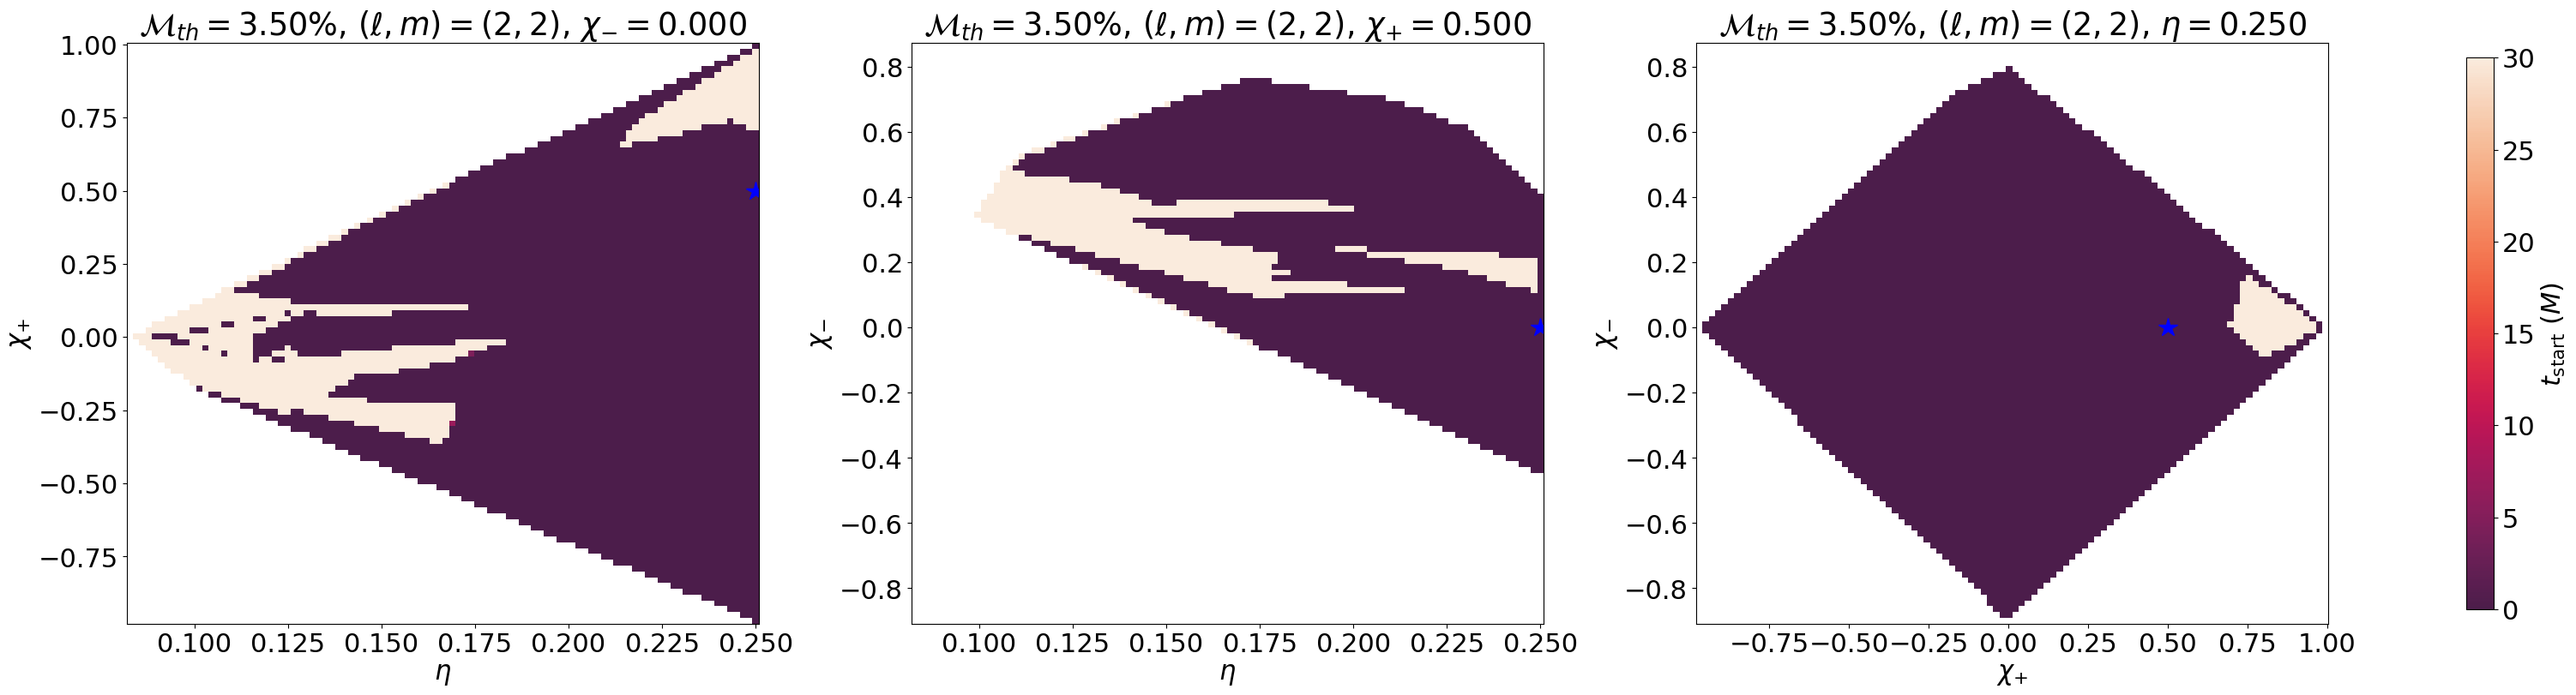

In [ ]:
# ---------------------------------------
# User inputs: slice position and threshold
# ---------------------------------------
eta_input   = float(input("Enter eta (between 0 and 0.25) [0.25]: ") or "0.25")
chip_input  = float(input("Enter chi_p (between -1 and 1) [0.5]: ") or "0.5")
chim_input  = float(input("Enter chi_m (between -1 and 1) [0.0]: ") or "0.0")

fixed_vals  = {"eta": eta_input, "chip": chip_input, "chim": chim_input}

single_threshold = float(input("Enter single mismatch threshold (e.g., 0.035) [0.035]: ") or "0.035")

print(
    f"\nInput progenitor parameters: (eta, chi+, chi-) = "
    f"({eta_input}, {chip_input}, {chim_input}).\n"
    f"Chosen mismatch threshold: {single_threshold}.\n"
)

# ---------------------------------------
# Crossing-time helper
# ---------------------------------------
def find_first_crossing_time(t_arr, mm_arr, thresh):
    """Return first interpolated t where mismatch falls below threshold."""
    sort_idx  = np.argsort(t_arr)
    t_sorted  = t_arr[sort_idx]
    mm_sorted = mm_arr[sort_idx]

    for i in range(1, len(mm_sorted)):
        if mm_sorted[i] <= thresh:
            t1, t2 = t_sorted[i-1], t_sorted[i]
            m1, m2 = mm_sorted[i-1], mm_sorted[i]

            if m2 == m1:  # avoid zero-division
                return t2

            slope = (m2 - m1) / (t2 - t1)
            return t1 + (thresh - m1) / slope

    return None

# ---------------------------------------
# Collect starting times for selected mode
# ---------------------------------------
t_start_keys   = list(avg_mismatches[model][mode].keys())
starting_times = sorted(float(t) for t in t_start_keys)

# ---------------------------------------
# Compute t_start for each NR simulation
# ---------------------------------------
crossing_records = []

for sim_id, params in id_info.items():
    ts, mm = [], []

    for t_start in starting_times:
        val = avg_mismatches.get(model, {}).get(mode, {}).get(t_start, {}).get(sim_id, np.nan)
        if val is not None and not np.isnan(val) and val > 0:
            ts.append(t_start)
            mm.append(val)

    if len(ts) < 2:
        t_cross = 100.0
    else:
        ts      = np.array(ts)
        mm      = np.array(mm)
        t_cross = find_first_crossing_time(ts, mm, single_threshold)
        if t_cross is None:
            t_cross = 100.0

    crossing_records.append({**params, "t": t_cross})

df_single = pd.DataFrame(crossing_records)

# ---------------------------------------
# Plot settings
# ---------------------------------------
label_map  = {"eta": r"\eta", "chip": r"\chi_{+}", "chim": r"\chi_{-}"}
axis_pairs = [("eta", "chip"), ("eta", "chim"), ("chip", "chim")]

cmap = ListedColormap(sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 1, 256)))
sm   = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=30))
sm.set_array([])

fig, axs = plt.subplots(1, 3, figsize=(30, 8), constrained_layout=True)
fig.colorbar(sm, ax=axs.ravel().tolist(), shrink=0.95).set_label(r"$t_{\rm start}~(M)$", fontsize=22)

# ---------------------------------------
# Interpolated contour maps for each plane
# ---------------------------------------
for idx, (x, y) in enumerate(axis_pairs):

    X = np.linspace(df_single[x].min(), df_single[x].max(), 100)
    Y = np.linspace(df_single[y].min(), df_single[y].max(), 100)
    Xg, Yg = np.meshgrid(X, Y)

    fixed_dim   = ({"eta", "chip", "chim"} - {x, y}).pop()
    fixed_value = fixed_vals[fixed_dim]

    pts = np.column_stack([
        Xg.ravel() if v == x else
        Yg.ravel() if v == y else
        np.full(Xg.size, fixed_value)
        for v in ["eta", "chip", "chim"]
    ])

    interp_vals = griddata(
        df_single[["eta","chip","chim"]].values,
        df_single["t"].values,
        pts,
        method='linear'
    )

    axs[idx].pcolormesh(
        Xg, Yg, interp_vals.reshape(Xg.shape),
        shading='auto', cmap=cmap, vmin=0, vmax=30
    )

    axs[idx].set_xlabel(f"${label_map[x]}$")
    axs[idx].set_ylabel(f"${label_map[y]}$")
    axs[idx].set_title(
        rf"$\mathcal{{M}}_{{th}}={single_threshold*100:.2f}\%$, "
        rf"$(\ell,m)=({mode[0]},{mode[1]})$, "
        rf"${label_map[fixed_dim]}={fixed_value:.3f}$"
    )

    axs[idx].plot(fixed_vals[x], fixed_vals[y], "b*", markersize=16)

# ---------------------------------------
# Evaluate interpolation at chosen point
# ---------------------------------------
query_point  = np.array([[fixed_vals["eta"], fixed_vals["chip"], fixed_vals["chim"]]])
t_interp     = griddata(df_single[["eta","chip","chim"]].values, df_single["t"].values, query_point, method='linear')
t_interp_val = t_interp.item()

eta_val, chip_val, chim_val = eta_input, chip_input, chim_input

if not np.isfinite(t_interp_val):
    print(f"\nPoint ({eta_val:.2f}, {chip_val:.2f}, {chim_val:.2f}) is outside interpolation region.\n")
elif t_interp_val > 30.0:
    print(f"\nModel not accurate enough near ({eta_val:.2f}, {chip_val:.2f}, {chim_val:.2f}).\n")
else:
    print(f"\nInterpolated start time: t_start = {t_interp_val:.1f} M "
          f"for (eta, chip, chim) = ({eta_val:.2f}, {chip_val:.2f}, {chim_val:.2f})\n")

plt.show()


**Now we plot the starting time interpolant map for different threshold**

The iteration is performed on $\mathcal{M}_{\rm th}\in[10^{-5},10^{-1}]$.

Saving animation to plots/animation_model_TEOBPM_mode_22.gif...

GIF saved as: plots/animation_model_TEOBPM_mode_22.gif



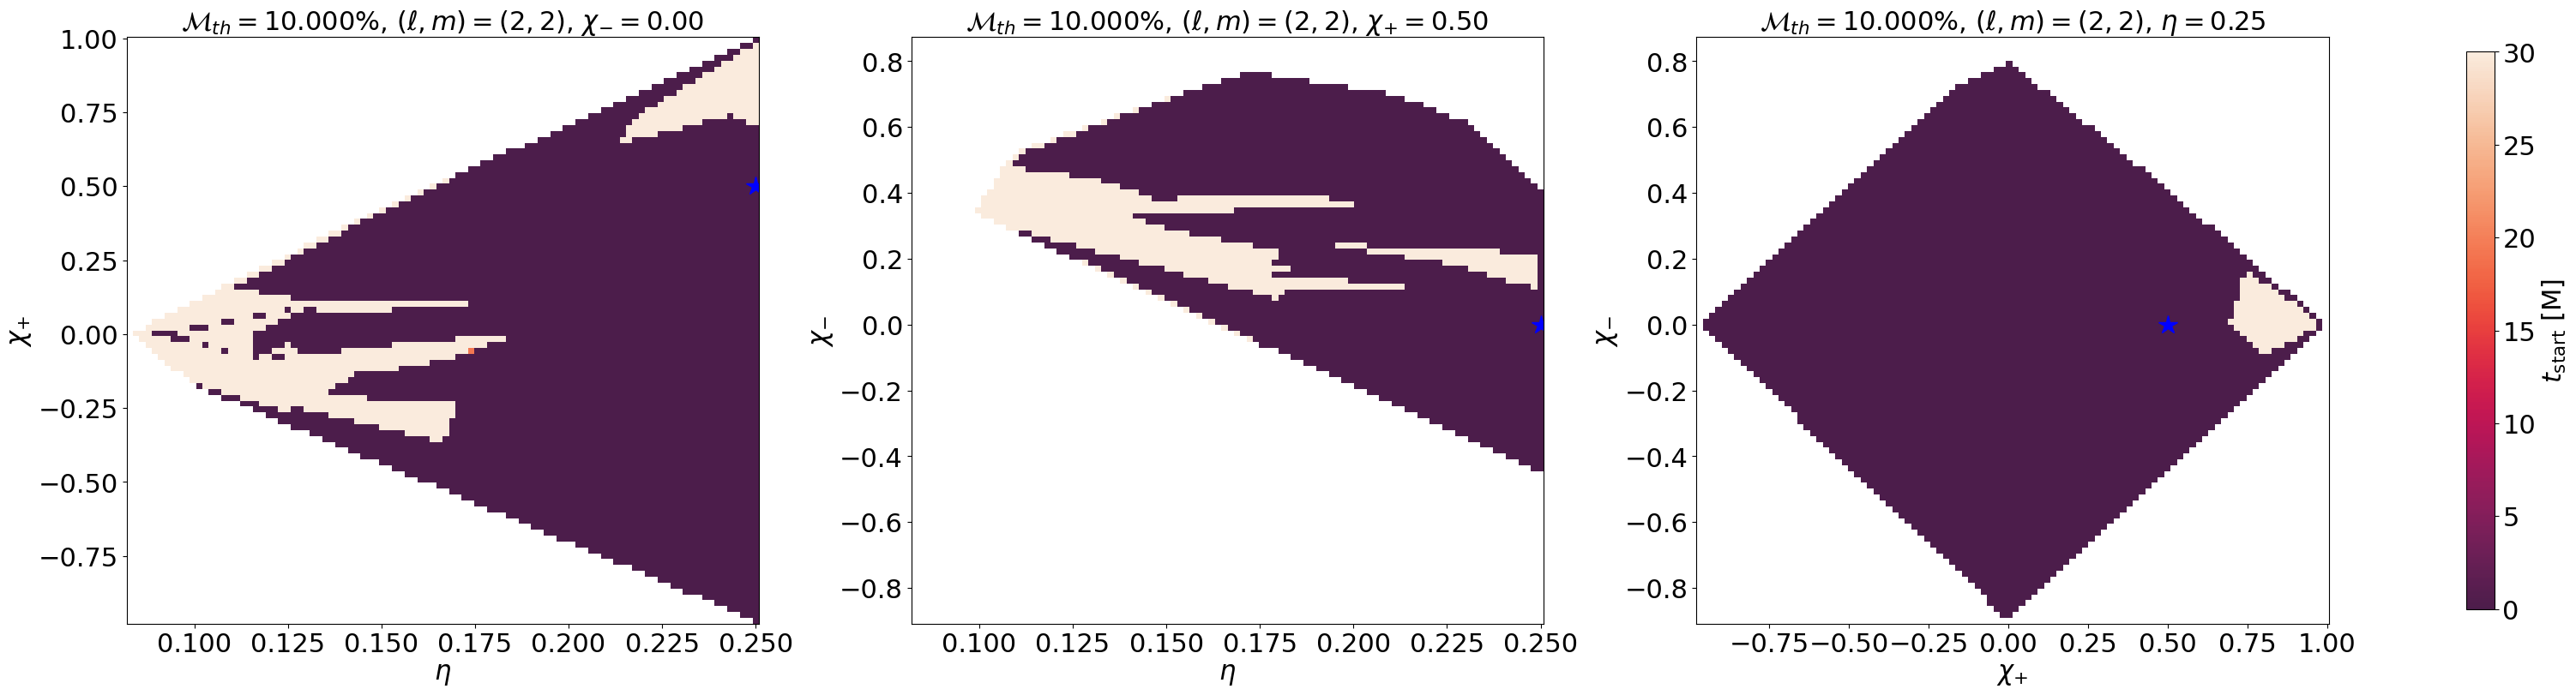

In [ ]:
# =======================================
# Animation: t_start maps vs mismatch threshold
# =======================================

# Threshold schedule: from 1e-1 → 1e-5 (log spaced)
thresholds = np.logspace(np.log10(1e-1), np.log10(1e-5), 12)

# ---------------------------------------
# Create figure and shared colorbar
# ---------------------------------------

fig_anim, axs_anim = plt.subplots(1, 3, figsize=(30, 8), constrained_layout=True)

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=30))
sm.set_array([])
cbar = fig_anim.colorbar(sm, ax=axs_anim.ravel().tolist(), shrink=0.95)
cbar.set_label(r"$t_{\rm start}~[\mathrm{M}]$", fontsize=22)

label_map = {"eta": r"\eta", "chip": r"\chi_{+}", "chim": r"\chi_{-}"}

# =======================================
# Frame update function
# =======================================

def update(th: float):
    """
    For a given mismatch threshold th:
    - compute first threshold-crossing time t_start for each simulation
    - interpolate over NR data
    - draw 2D slices for (eta, chip), (eta, chim), (chip, chim)
    """

    # -----------------------------------
    # Compute threshold-crossing times
    # -----------------------------------
    crossing = []

    for sim_id, params in id_info.items():
        ts, mm = [], []

        # Gather mismatch curve for this simulation
        for t_start in starting_times:
            val = avg_mismatches.get(model, {}).get(mode, {}).get(t_start, {}).get(sim_id, np.nan)
            if val is not None and not np.isnan(val) and val > 0:
                ts.append(t_start)
                mm.append(val)

        # Too few points → no interpolation possible
        if len(ts) < 2:
            t_cross = 100.0
        else:
            t_cross = find_first_crossing_time(np.array(ts), np.array(mm), th)
            if t_cross is None:
                t_cross = 100.0

        crossing.append({**params, "t": t_cross})

    df = pd.DataFrame(crossing)

    # -----------------------------------
    # Clear axes for next frame
    # -----------------------------------
    for ax in axs_anim:
        ax.clear()

    # -----------------------------------
    # Loop over 2D planes
    # -----------------------------------
    for idx, (x, y) in enumerate(axis_pairs):

        # Build regular grid across (x,y)
        X   = np.linspace(df[x].min(), df[x].max(), 100)
        Y   = np.linspace(df[y].min(), df[y].max(), 100)
        Xg, Yg = np.meshgrid(X, Y)

        # Variable not shown (held fixed)
        fixed_dim   = ({"eta", "chip", "chim"} - {x, y}).pop()
        fixed_value = fixed_vals[fixed_dim]

        pts = np.column_stack([
            Xg.ravel() if v == x else
            Yg.ravel() if v == y else
            np.full(Xg.size, fixed_value)
            for v in ["eta", "chip", "chim"]
        ])

        # Interpolate t_start field
        t_interp = griddata(
            df[["eta", "chip", "chim"]],
            df["t"],
            pts,
            method='linear'
        )

        axs_anim[idx].pcolormesh(
            Xg, Yg,
            t_interp.reshape(Xg.shape),
            shading='auto',
            cmap=cmap,
            vmin=0, vmax=30
        )

        # Axis labels
        axs_anim[idx].set_xlabel(rf"${label_map[x]}$", fontsize=22)
        axs_anim[idx].set_ylabel(rf"${label_map[y]}$", fontsize=22)

        # Figure title
        axs_anim[idx].set_title(
            rf"$\mathcal{{M}}_{{th}} = {th*100:.3f}\%$, "
            rf"$(\ell,m)=({mode[0]},{mode[1]})$, "
            rf"${label_map[fixed_dim]} = {fixed_value:.2f}$",
            fontsize=22
        )

        # Mark the evaluation point
        axs_anim[idx].plot(fixed_vals[x], fixed_vals[y], "b*", markersize=16)


# =======================================
# Render animation
# =======================================

ani = FuncAnimation(fig_anim, update, frames=thresholds, interval=500)

HTML(ani.to_jshtml())

# Save GIF
gif_name = f"plots/animation_model_{model}_mode_{mode}.gif"
print(f"Saving animation to {gif_name}...\n")
ani.save(gif_name, writer=PillowWriter(fps=2))
print(f"GIF saved as: {gif_name}\n")